# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

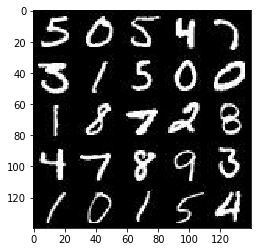

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

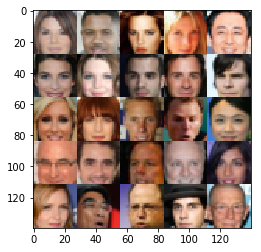

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        cov1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        cov1 = tf.maximum(cov1 * alpha, cov1)
        # Now 14x14x128
        cov2 = tf.layers.conv2d(cov1, 256, 5, strides=2, padding='same')
        cov2 = tf.layers.batch_normalization(cov2, training=True)
        cov2 = tf.maximum(cov2 * alpha, cov2)
        # Now 7x7x256
        flat = tf.reshape(cov2, (-1,7*7*256))
        logits = tf.contrib.layers.fully_connected(flat, 1, activation_fn=None)
        outputs = tf.sigmoid(logits)
        
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        x = tf.contrib.layers.fully_connected(z, 7*7*256, activation_fn=None)
        x = tf.reshape(x, (-1,7,7,256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #Now 7x7x256
        cov1 = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        cov1 = tf.layers.batch_normalization(cov1, training=is_train)
        cov1 = tf.maximum(alpha * cov1, cov1)
        #Now 14x14x128
        logits = tf.layers.conv2d_transpose(cov1, out_channel_dim, 5, strides=2, padding='same')
        #Now 28x28x3
        outputs = tf.tanh(logits)
    return outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real) * (0.9)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    a_var = tf.trainable_variables()
    d_var = [var for var in a_var if var.name.startswith('discriminator')]
    g_var = [var for var in a_var if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=d_var)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_var)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim )
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate=learning_rate, beta1=beta1)
    
    

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # (-0.5, 0.5) to (1.0, 1.0)
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr:learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr:learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 72, input_z, data_shape[3], data_image_mode)
        print('Trained')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.8365... Generator Loss: 1.0618
Epoch 1/2... Discriminator Loss: 1.9389... Generator Loss: 3.2941
Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 3.2211
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 2.3829
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 2.5278
Epoch 1/2... Discriminator Loss: 1.4858... Generator Loss: 2.7012
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 2.1355
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 2.3595
Epoch 1/2... Discriminator Loss: 1.5037... Generator Loss: 2.3777
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 1.5425


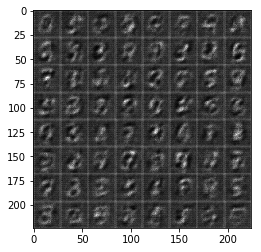

Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 1.4863
Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 1.4412
Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 1.5471
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 1.4160
Epoch 1/2... Discriminator Loss: 1.1530... Generator Loss: 1.6847
Epoch 1/2... Discriminator Loss: 1.0000... Generator Loss: 1.4606
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 1.7524
Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 1.7539
Epoch 1/2... Discriminator Loss: 1.0594... Generator Loss: 1.3725
Epoch 1/2... Discriminator Loss: 1.1321... Generator Loss: 1.8348


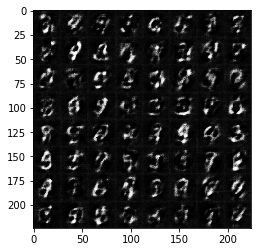

Epoch 1/2... Discriminator Loss: 1.1926... Generator Loss: 1.9765
Epoch 1/2... Discriminator Loss: 1.1467... Generator Loss: 1.8332
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 1.6112
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 1.9939
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 1.6513
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 1.5873
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 1.2259
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 2.1315
Epoch 1/2... Discriminator Loss: 1.0567... Generator Loss: 1.5402
Epoch 1/2... Discriminator Loss: 1.0093... Generator Loss: 1.6819


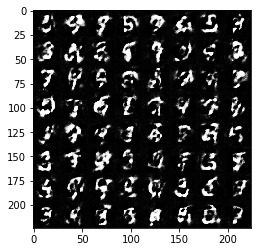

Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 1.5586
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 1.0577
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 0.7823
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 1.7458
Epoch 1/2... Discriminator Loss: 0.8995... Generator Loss: 1.1333
Epoch 1/2... Discriminator Loss: 1.0102... Generator Loss: 0.8304
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 0.8327
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.6872
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 0.9178
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 0.8094


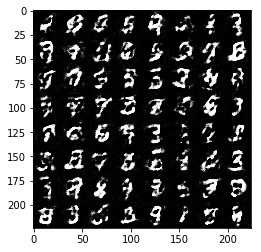

Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 1.2563
Epoch 1/2... Discriminator Loss: 1.4461... Generator Loss: 0.4708
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 1.8731
Epoch 1/2... Discriminator Loss: 0.9371... Generator Loss: 1.0113
Epoch 1/2... Discriminator Loss: 1.2614... Generator Loss: 2.4113
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 2.3336
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 1.6324
Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 1.0070


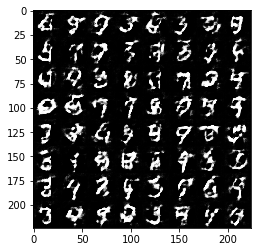

Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 0.6756
Epoch 1/2... Discriminator Loss: 1.1176... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 1.2359
Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 1.3481
Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 1.9905
Epoch 1/2... Discriminator Loss: 1.0000... Generator Loss: 1.8337
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 1.6422
Epoch 1/2... Discriminator Loss: 1.4906... Generator Loss: 0.4498


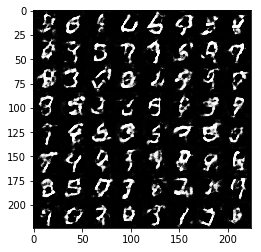

Epoch 1/2... Discriminator Loss: 0.9212... Generator Loss: 1.0401
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 0.7503
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.4828
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.3538
Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 1.0998
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.5472
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 1.6517
Epoch 1/2... Discriminator Loss: 1.0830... Generator Loss: 1.6797
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 1.5414


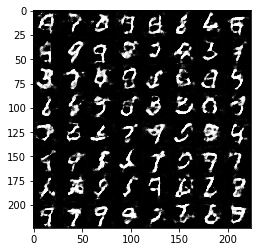

Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 2.0940
Epoch 1/2... Discriminator Loss: 0.9781... Generator Loss: 1.5013
Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 1.1516
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 1.0892
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 0.9167
Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 0.6554
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.4871
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 0.8687
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 1.3732


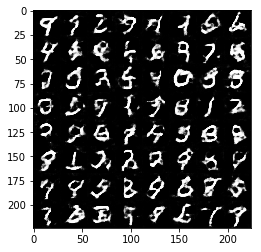

Epoch 1/2... Discriminator Loss: 1.1431... Generator Loss: 1.4629
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 1.3301
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 1.6968
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 1.5083
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 1.5026
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 1.7654
Epoch 1/2... Discriminator Loss: 0.9571... Generator Loss: 1.1634
Epoch 1/2... Discriminator Loss: 1.7669... Generator Loss: 2.4828
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 1.2365
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 1.2699


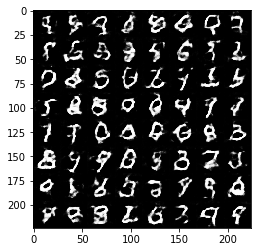

Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 1.0115
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.6371
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 0.6525
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.9443
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.5143
Epoch 2/2... Discriminator Loss: 1.0783... Generator Loss: 0.8736
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.6218
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 0.5234
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.6994


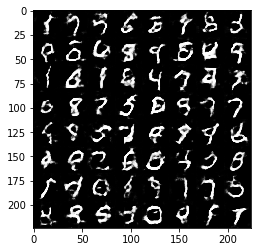

Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.6581
Epoch 2/2... Discriminator Loss: 1.2641... Generator Loss: 0.5897
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 1.1922
Epoch 2/2... Discriminator Loss: 1.0846... Generator Loss: 1.3890
Epoch 2/2... Discriminator Loss: 1.8264... Generator Loss: 2.4186
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 1.0388
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 0.9907
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 1.9474... Generator Loss: 2.7241


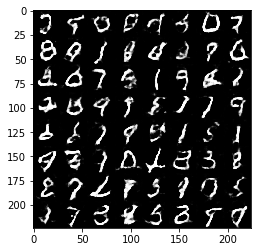

Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 1.2157
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 1.2788
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 0.9364
Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.4885
Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 0.6109
Epoch 2/2... Discriminator Loss: 1.0180... Generator Loss: 0.8678
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 1.0458
Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 0.6336


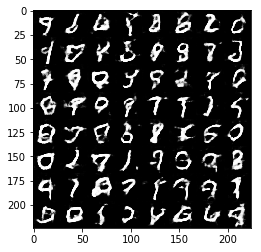

Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 0.6433
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 0.7634
Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 0.7571
Epoch 2/2... Discriminator Loss: 1.0038... Generator Loss: 1.0765
Epoch 2/2... Discriminator Loss: 1.4729... Generator Loss: 2.1102
Epoch 2/2... Discriminator Loss: 1.0093... Generator Loss: 1.0418
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 0.9190
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 0.7685
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.5593


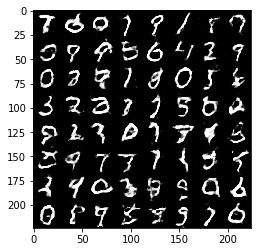

Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 0.7982
Epoch 2/2... Discriminator Loss: 1.0117... Generator Loss: 0.9276
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 1.5576
Epoch 2/2... Discriminator Loss: 0.9907... Generator Loss: 1.2312
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 0.9367
Epoch 2/2... Discriminator Loss: 1.4480... Generator Loss: 2.2123
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 1.2811
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 0.8140
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 0.7816
Epoch 2/2... Discriminator Loss: 0.9941... Generator Loss: 1.4391


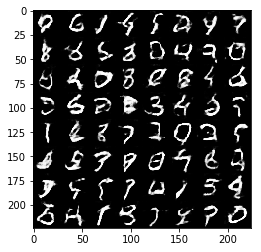

Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 1.4332
Epoch 2/2... Discriminator Loss: 1.0477... Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 1.5838... Generator Loss: 0.4035
Epoch 2/2... Discriminator Loss: 1.0430... Generator Loss: 0.8423
Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 0.8230
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 1.4515
Epoch 2/2... Discriminator Loss: 0.9625... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.2738
Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 1.2070
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 1.3895


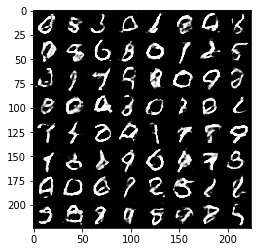

Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 1.0486
Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 1.2411
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 1.6672
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 1.4048
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 0.9768
Epoch 2/2... Discriminator Loss: 0.9800... Generator Loss: 1.3046
Epoch 2/2... Discriminator Loss: 0.9698... Generator Loss: 1.3011
Epoch 2/2... Discriminator Loss: 1.0857... Generator Loss: 0.7415
Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 1.4111
Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 1.8625


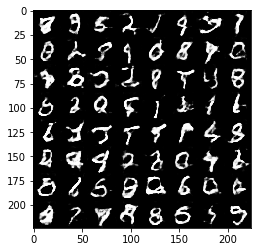

Epoch 2/2... Discriminator Loss: 2.1393... Generator Loss: 3.0181
Epoch 2/2... Discriminator Loss: 0.9779... Generator Loss: 0.9943
Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 0.9005
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 1.3396
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 1.4547
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 1.7575... Generator Loss: 0.3743
Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 1.2297
Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 1.4514


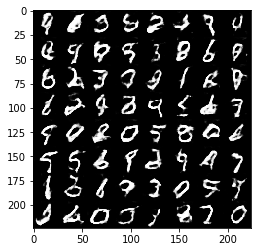

Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 0.9136
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 1.3719
Epoch 2/2... Discriminator Loss: 1.1191... Generator Loss: 1.9168
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 1.3821
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 2.4308
Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 1.5767
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 1.0697
Epoch 2/2... Discriminator Loss: 1.7767... Generator Loss: 2.7935
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 1.2175
Epoch 2/2... Discriminator Loss: 0.8807... Generator Loss: 1.3996


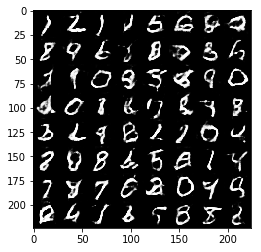

Epoch 2/2... Discriminator Loss: 0.9348... Generator Loss: 1.1346
Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 1.3061
Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 1.9019
Epoch 2/2... Discriminator Loss: 2.2556... Generator Loss: 3.6042
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 1.3211
Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 1.3517
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.5182
Trained


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 2.2057
Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 2.2797
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 1.7028
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 4.1196
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 4.2082
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 2.2988
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.9514
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.6725
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 2.2574


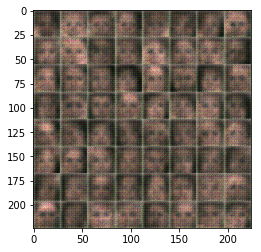

Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 2.9010
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.5214
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.4351
Epoch 1/1... Discriminator Loss: 1.7701... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.8420... Generator Loss: 0.3493
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.5017


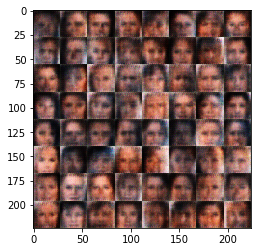

Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 1.4520
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.4083
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 1.9680... Generator Loss: 0.2560
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.9375


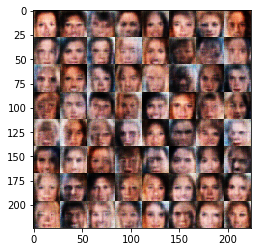

Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 2.0913
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.6488
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 2.2485... Generator Loss: 5.1559
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6515


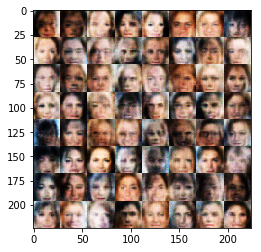

Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.4481
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 2.1146
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 2.7665... Generator Loss: 0.1545
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 2.3374
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.1554


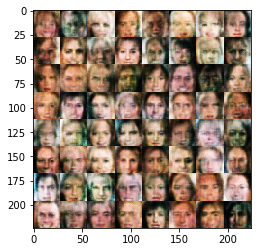

Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.6208
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.7184... Generator Loss: 0.3845
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.8933


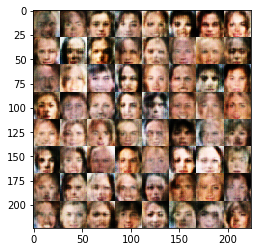

Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 1.3312
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.8009... Generator Loss: 0.3466
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 1.5018
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6448


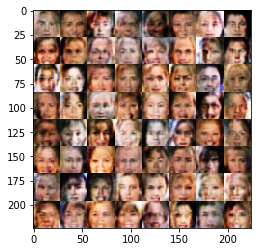

Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 1.0244


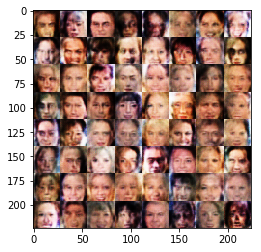

Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 1.1970
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.0944


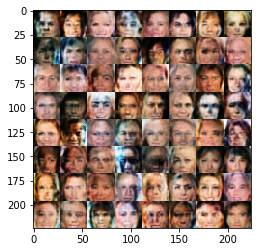

Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.9739


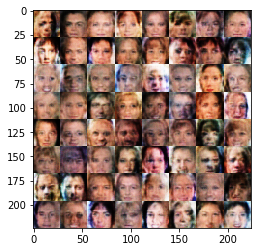

Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.7164
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.3821
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.0418


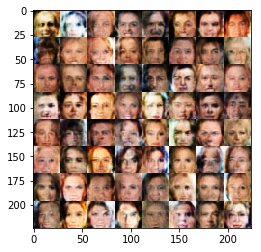

Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 1.6257
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.2534
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.5893


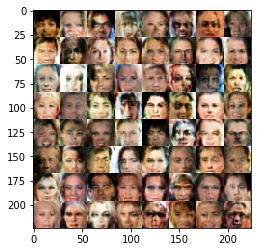

Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.6887
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 1.9182
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.1994
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 1.8961
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.3594


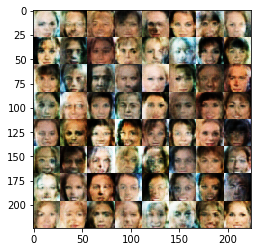

Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.3895
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.3615
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 1.2545
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.5071
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.7637


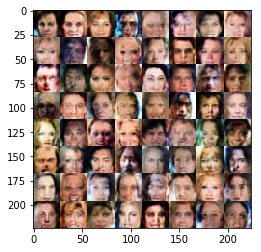

Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 1.5583
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 2.0390
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 2.5047
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.7869
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.1838


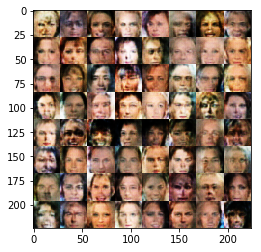

Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.9243
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 2.5816
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.7822
Trained


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.